In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vgg16/imagenet_class_index.json
/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0125.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0223.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0030.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0141.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0226.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0203.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0048.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0070.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0212.JPEG
/kaggle/input/car-damage-detection/cars/data1a/validation/00-damage/0002.JPEG
/kaggle/input/car-damage-detection/cars/

In [2]:
!pip install --upgrade imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25859 sha256=1f8f2c9ba2c25a21c989df878b0616a2bfca521e42bc7bb055c260a36dc9092b
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-5
EPOCHS = 50
BS = 64

DIRECTORY = r"../input/car-damage-detection/data1a/training/"
DIRECTORY2=r"../input/car-damage-detection/data1a/validation/"
CATEGORIES = ["00-damage", "01-whole"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)


for category in CATEGORIES:
    path = os.path.join(DIRECTORY2, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)
       
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)



(trainX, testX, trainY, testY) = train_test_split(data, labels,
test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

[INFO] loading images...


In [5]:
baseModel =  VGG19(weights="imagenet", include_top=False, input_tensor=Input (shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
#the base model
headModel= baseModel.output 
headModel= MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel) 
headModel= Dropout(0.5)(headModel) 
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become # the actual model we will train) 
model=Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will # not be updated during the first training process 

80134624/80134624 [==============================] - 1s 0us/step


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
for layer in baseModel.layers:
    layer.trainable = True
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

print("[INFO]training head...")
H= model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX)//BS,
    validation_data=(testX,testY),
    validation_steps=len(testX)//BS,
    epochs=5)

[INFO] compiling model...
[INFO]training head...
Epoch 1/5
28/28 [==============================] - 69s 2s/step - loss: 12.9756 - accuracy: 0.5023 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
28/28 [==============================] - 30s 1s/step - loss: 0.6954 - accuracy: 0.5101 - val_loss: 0.6928 - val_accuracy: 0.5065
Epoch 3/5
28/28 [==============================] - 29s 1s/step - loss: 0.6929 - accuracy: 0.5079 - val_loss: 0.6931 - val_accuracy: 0.5043
Epoch 4/5
28/28 [==============================] - 29s 1s/step - loss: 0.6898 - accuracy: 0.5535 - val_loss: 0.6929 - val_accuracy: 0.5109
Epoch 5/5
28/28 [==============================] - 29s 1s/step - loss: 0.6913 - accuracy: 0.5332 - val_loss: 0.6931 - val_accuracy: 0.5022


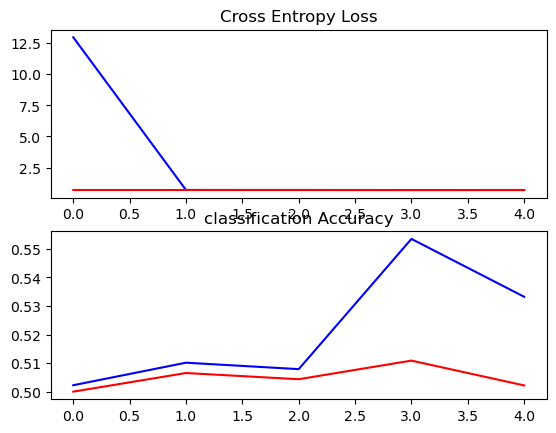

In [8]:
from matplotlib import pyplot as plt

plt.subplot(2,1,1)
plt.title('Cross Entropy Loss')
plt.plot(H.history['loss'],color='blue',label= 'train')
plt.plot(H.history['val_loss'],color='red',label= 'test')


plt.subplot(2,1,2)
plt.title('classification Accuracy')
plt.plot(H.history['accuracy'],color='blue',label= 'train')
plt.plot(H.history['val_accuracy'],color='red',label='test')
plt.show()